* <a href="#Model1">ACT</a>
* <a href="#Model2">Enrollment</a>

In [56]:
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

In [27]:
%matplotlib notebook
import pandas as pd
import numpy as np
import yellowbrick as yb
import matplotlib.pyplot as plt
#import xgboost as xgb
from pprint import pprint
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectPercentile, f_regression, mutual_info_regression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer, scale
from sklearn.svm import LinearSVC, NuSVC, SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier, RidgeClassifier, LinearRegression
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, cross_validate
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ClassPredictionError, ROCAUC
from yellowbrick.features import Rank1D, Rank2D, RFECV
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import ValidationCurve, LearningCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection

In [11]:
pd.options.display.max_columns = None

In [12]:
# rmse, mape functions take from :https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/High%20School%20Minority%20Percentage%20February%202018.ipynb
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

In [13]:
# Some setup is required before you can use this because token must be kept private
# I also need to add your name and unique identifier to the dictionary userID below
import os
from slackclient import SlackClient
from dotenv import load_dotenv

load_dotenv()

userID = {"brett": "UAN6UQEVC"}

slackToken = os.environ["SLACK_BOT_TOKEN"]
sc = SlackClient(slackToken)

def sendSlackMessage(msg, user):
    result = sc.api_call(
    "chat.postMessage",
    channel=userID[user.lower()],
    text=msg)
    
    if (not result['ok']):
        print("Error: {}".format(result))

<a id="Model1"></a>
### ACT

In [14]:
# Brett's directory
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directory
#%cd "C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\Project\2017\Machine Learning Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

# Target variable
y = dfPublicHS['ACT Score']

# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)
keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes',
              '4_10_Years_LEA_Exp_Pct_Prin': 'Four_to_Ten_Years_Exp_Pct_prin',
              '10+_Years_LEA_Exp_Pct_Prin': 'Ten_Plus_Years_LEA_Exp_Pct_prin',
              '0_3_Years_LEA_Exp_Pct_Prin': 'One_to_three_lea_exp_pct_prin'}

# Remove any trailing white spaces
dfPublicHS.columns = dfPublicHS.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfPublicHS.columns = dfPublicHS.columns.str.replace(r' |/|-|,|\+|:', "_")

# Rename columns
dfPublicHS.rename(columns=renameCols, inplace = True)

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets
Columns Dropped: 1


In [15]:
# Drop any remaining variables related to the ACT score (such as ACT benchmarks) to not bias our model
dropCols = dfPublicHS.filter(regex = r'ACT')
dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# Data
X = dfPublicHS.iloc[:,0:dfPublicHS.shape[1] - 1]

In [17]:
# Credit: https://www.kaggle.com/cast42/select-features-rfecv/code
p = 40
selectF_regression = SelectPercentile(f_regression, percentile=p).fit(X, y)
select_mutual = SelectPercentile(mutual_info_regression, percentile=p).fit(X, y)

f_regression_selected = selectF_regression.get_support()
f_regression_selected_features = [ f for i,f in enumerate(X.columns) if f_regression_selected[i]]
print('f_regression selected {} features.'.format(f_regression_selected.sum()))

mutual_selected = select_mutual.get_support()
mutual_selected_features = [ f for i,f in enumerate(X.columns) if mutual_selected[i]]
print('Mutual Info Regression selected {} features.'.format(mutual_selected.sum()))

selected = f_regression_selected & mutual_selected
print('Intersection of F_Regression & Mutual Info Regression: {} features'.format(selected.sum()))
featuresFull = [ f for f,s in zip(X.columns, selected) if s]

f_regression selected 126 features.
Mutual Info Regression selected 126 features.
Intersection of F_Regression & Mutual Info Regression: 88 features


In [ ]:
cv = ShuffleSplit(n_splits = 10, test_size  = 0.2, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X[featuresFull], y, random_state=42, test_size=.2)

<IPython.core.display.Javascript object>


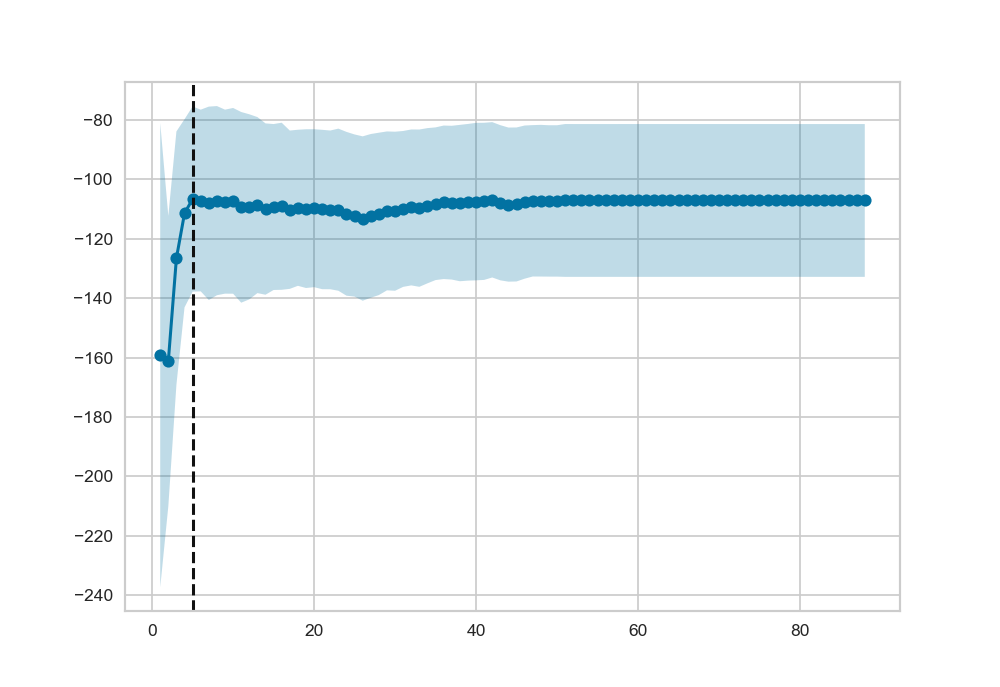

The optimal number of features is 5


In [18]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

selector = RFECV(Lasso(), cv = cv, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
featuresLasso = [f for f,s in zip(X_train.columns, selector.support_) if s]

sendSlackMessage("RFE finished", "Brett")

<IPython.core.display.Javascript object>


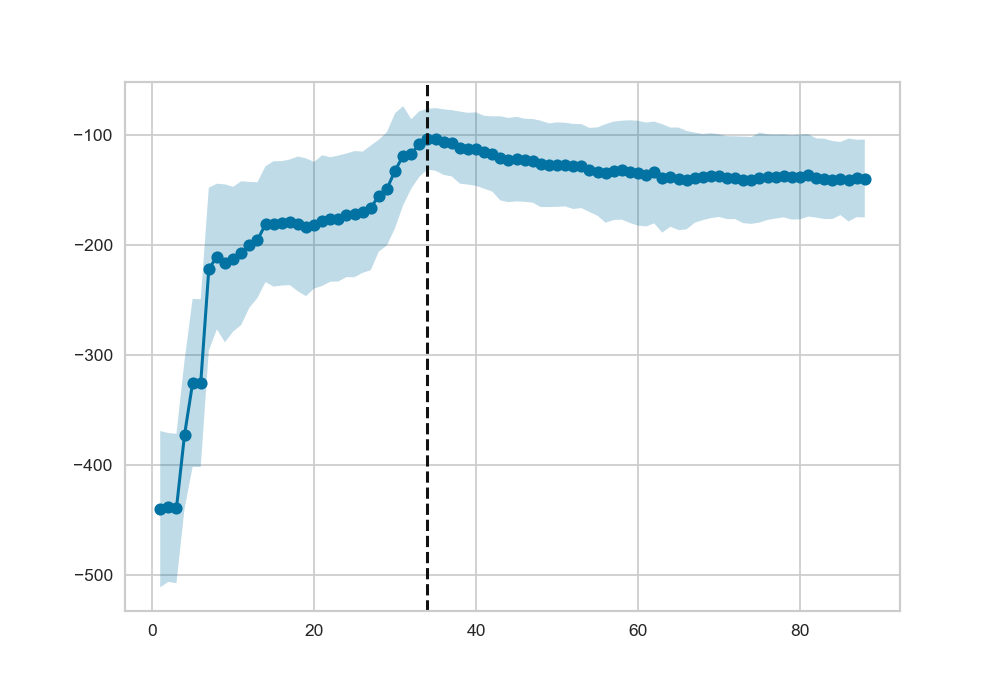

The optimal number of features is 34


In [19]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Feature Selection
selector = RFECV(LinearRegression(n_jobs=-1), cv = cv, scoring = 'neg_mean_squared_error')
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
featuresLR = [f for f,s in zip(X_train.columns, selector.support_) if s]

sendSlackMessage("RFE finished", "Brett")

In [37]:
featureList = [featuresFull, featuresLasso, featuresLR]

<IPython.core.display.Javascript object>


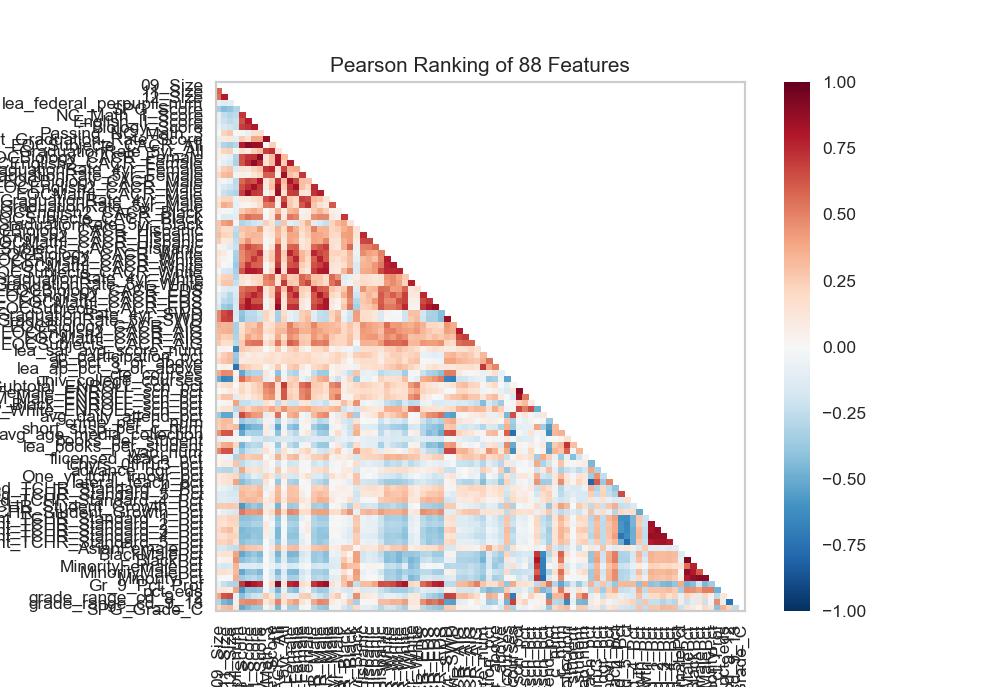

C:\Users\brett\Anaconda64\lib\site-packages\yellowbrick\features\rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()


In [20]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresFull, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresFull], y)
vis.transform(dfPublicHS[featuresFull])
vis.poof()

<IPython.core.display.Javascript object>


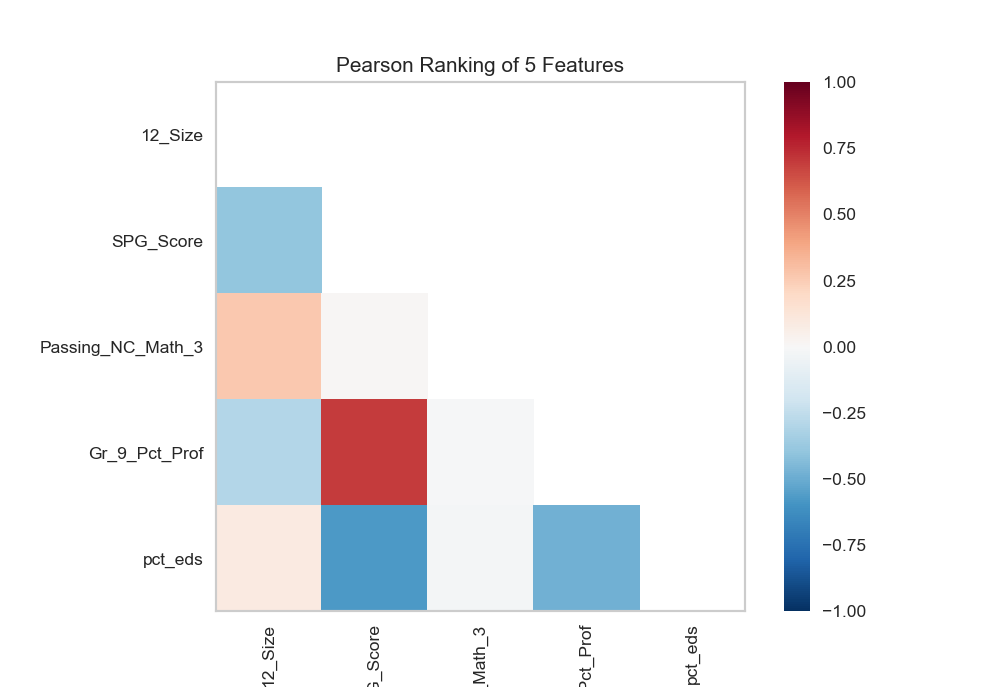

In [22]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresLasso, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresLasso], y)
vis.transform(dfPublicHS[featuresLasso])
vis.poof()

<IPython.core.display.Javascript object>


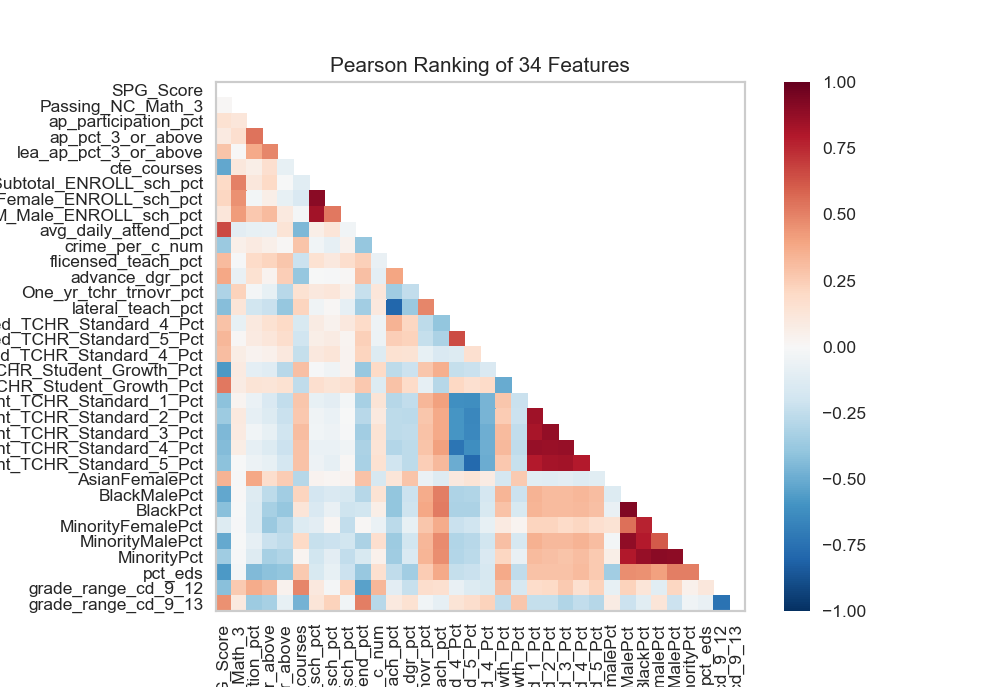

In [23]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresLR, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresLR], y)
vis.transform(dfPublicHS[featuresLR])
vis.poof()

In [79]:
featureList = [featuresFull, featuresLasso, featuresLR]

def getTrainTestValues(features):
    return train_test_split(X[features], y, random_state=42, test_size=.2)

<IPython.core.display.Javascript object>


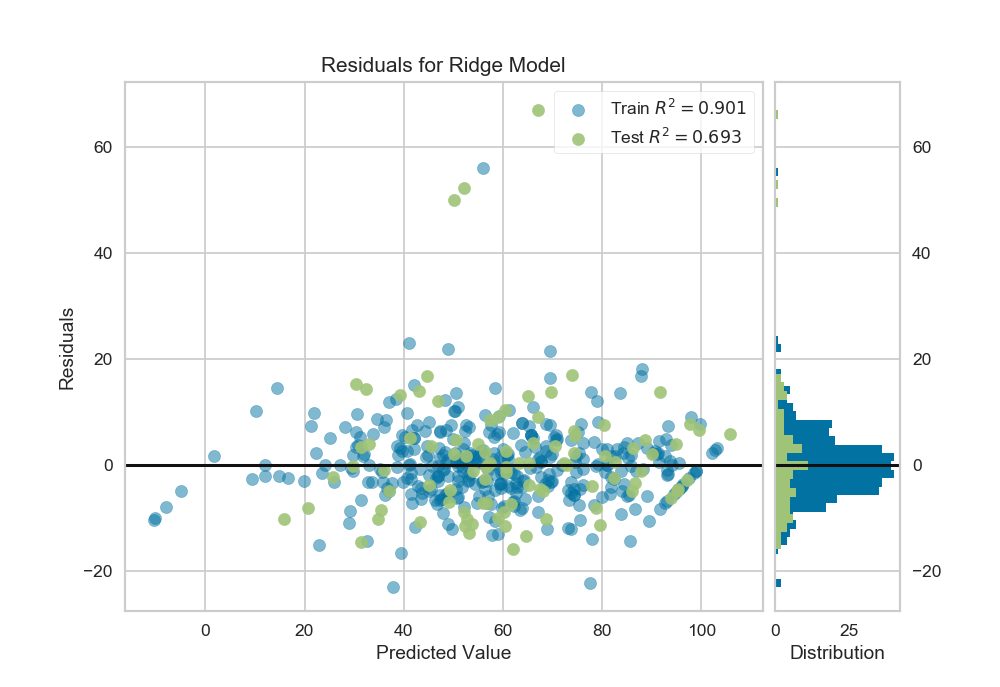

C:\Users\brett\Anaconda64\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\brett\Anaconda64\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
C:\Users\brett\Anaconda64\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


<IPython.core.display.Javascript object>


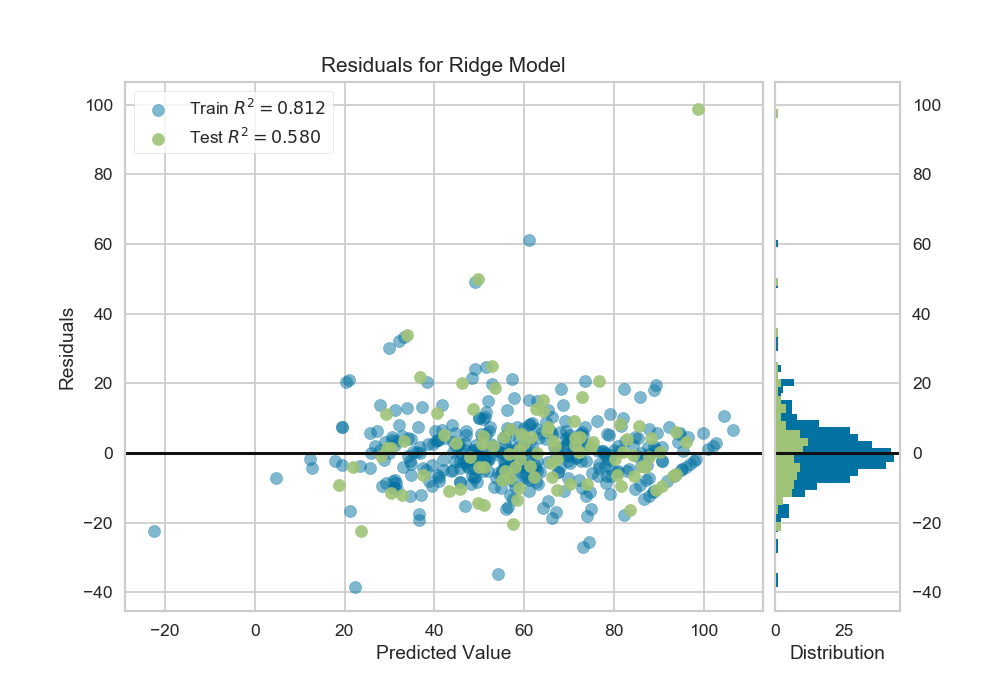

<IPython.core.display.Javascript object>


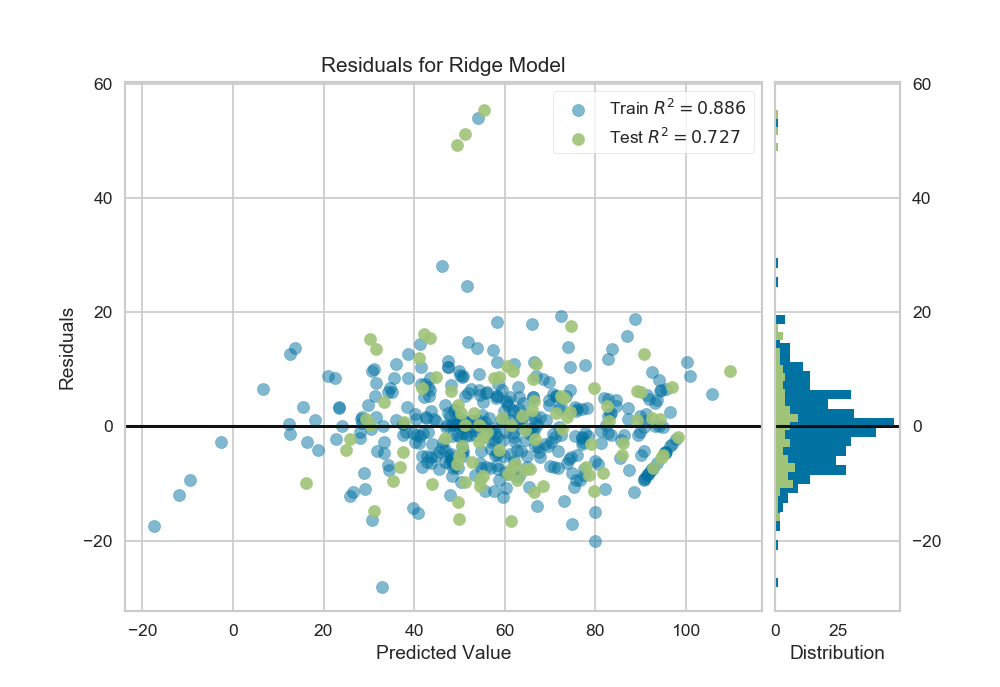

C:\Users\brett\Anaconda64\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\brett\Anaconda64\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
C:\Users\brett\Anaconda64\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [84]:
# Scale data after splitting out test data
scaler = StandardScaler()

# Instantiate the linear model and visualizer
ridge = Ridge()

for f in featureList:
    # Create a new matplotlib figure
    fig = plt.figure()
    ax = fig.add_subplot()
    
    X_train, X_test, y_train, y_test = getTrainTestValues(f)
    
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    visualizer = ResidualsPlot(ridge, ax = ax)
    visualizer.fit(X_train, y_train)  # Fit the training data to the model
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.poof()                 # Draw/show/poof the data

Feature options: ['SPG_Score', 'NC_Math_1_Score', 'English_II_Score', 'Biology_Score', 'EOCSubjects_CACR_All', 'EOCBiology_CACR_Female', 'EOCEnglish2_CACR_Female', 'EOCBiology_CACR_Male', 'EOCEnglish2_CACR_Male', 'EOCMathI_CACR_Male', 'EOCSubjects_CACR_Hispanic', 'EOCEnglish2_CACR_White', 'EOCMathI_CACR_White', 'EOCSubjects_CACR_White', 'EOCBiology_CACR_EDS', 'EOCEnglish2_CACR_EDS', 'EOCMathI_CACR_EDS', 'EOCSubjects_CACR_EDS', 'EOCBiology_CACR_SWD', 'EOCBiology_GLP_SWD', 'EOCEnglish2_CACR_SWD', 'EOCEnglish2_GLP_SWD', 'EOCMathI_CACR_SWD', 'GraduationRate_4yr_SWD', 'GraduationRate_5yr_SWD', 'univ_college_courses', 'MB_Black_ENROLL_sch_pct', 'MW_White_ENROLL_sch_pct', 'avg_daily_attend_pct', 'short_susp_per_c_num', 'expelled_per_c_num', 'lea_short_susp_per_c_num', 'nbpts_num', 'lateral_teach_pct', 'Developing_TCHR_Standard_1_Pct', 'Developing_TCHR_Standard_2_Pct', 'Developing_TCHR_Standard_4_Pct', 'Does_Not_Meet_Expected_Growth_TCHR_Student_Growth_Pct', 'Proficient_TCHR_Standard_1_Pct', '

<IPython.core.display.Javascript object>


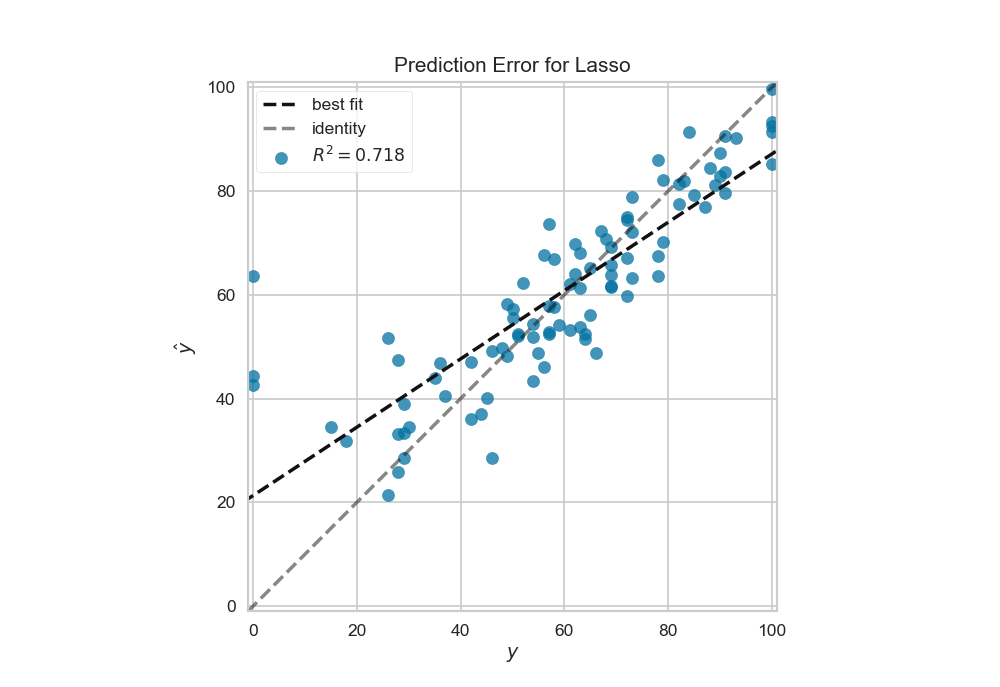

Feature options: ['SPG_Score', 'NC_Math_1_Score', 'Biology_Score', 'EOCSubjects_CACR_All', 'EOCBiology_CACR_Male', 'EOCEnglish2_CACR_Male', 'EOCEnglish2_CACR_White', 'EOCMathI_CACR_White', 'EOCBiology_GLP_SWD', 'MB_Black_ENROLL_sch_pct', 'MW_White_ENROLL_sch_pct', 'Gr_9_Pct_Prof', 'pct_eds']


C:\Users\brett\Anaconda64\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\brett\Anaconda64\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\brett\Anaconda64\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


<IPython.core.display.Javascript object>


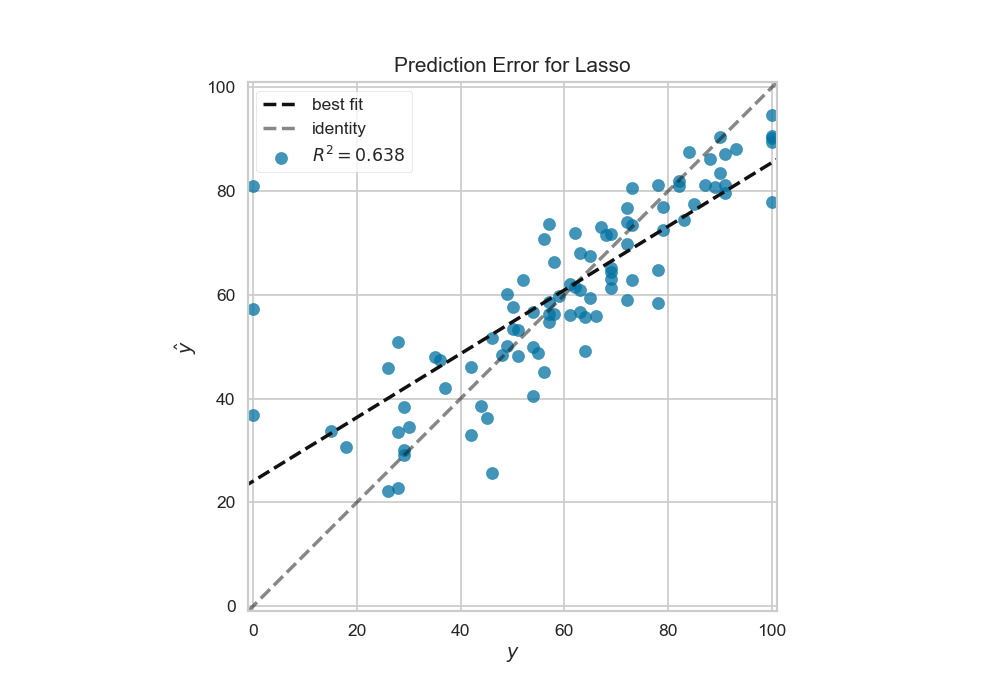

Feature options: ['SPG_Score', 'MB_Black_ENROLL_sch_pct', 'avg_daily_attend_pct', 'expelled_per_c_num', 'lateral_teach_pct', 'Developing_TCHR_Standard_1_Pct', 'Developing_TCHR_Standard_2_Pct', 'Developing_TCHR_Standard_4_Pct', 'Does_Not_Meet_Expected_Growth_TCHR_Student_Growth_Pct', 'Proficient_TCHR_Standard_1_Pct', 'Proficient_TCHR_Standard_4_Pct', 'AsianFemalePct', 'BlackFemalePct', 'BlackMalePct', 'BlackPct', 'MinorityFemalePct', 'MinorityMalePct', 'MinorityPct', 'pct_eds', 'grade_range_cd_7_13', 'grade_range_cd_9_13', 'grade_range_cd_9_9', 'SPG_Grade_B', 'Reading_SPG_Grade_C', 'Reading_SPG_Grade_D', 'Math_SPG_Grade_D', 'EVAAS_Growth_Status_NotMet', 'State_Gap_Compared_Y', 'grades_BYOD_9_10_11_12_13', 'grades_BYOD_9_11_12', 'grades_1_to_1_access_10_11_12', 'grades_1_to_1_access_6_7_8_9_10_11_12_13', 'grades_1_to_1_access_9_11_12_13', 'SRC_Grades_Devices_Sent_Home_6_7_8_9_10_11_12_13', 'SRC_Grades_Devices_Sent_Home_9_10_11_12_13']


<IPython.core.display.Javascript object>


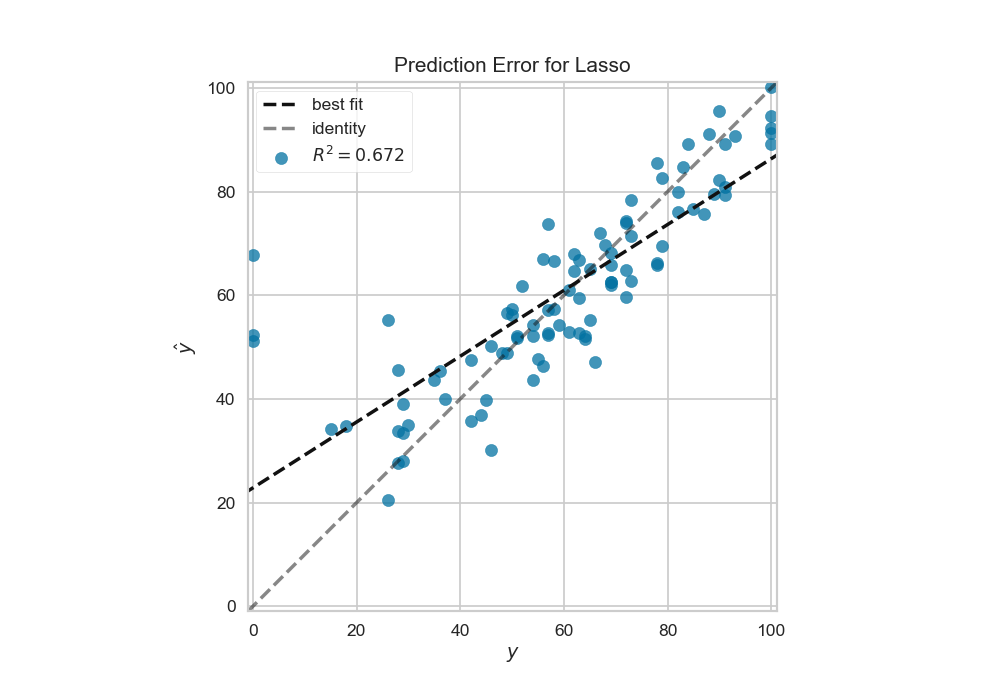

C:\Users\brett\Anaconda64\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\brett\Anaconda64\lib\site-packages\ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
C:\Users\brett\Anaconda64\lib\site-packages\ipykernel_launcher.py:18: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [86]:
# Scale data after splitting out test data
scaler = StandardScaler()

# Instantiate the linear model and visualizer
lasso = Lasso()

for f in featureList:
    # Create a new matplotlib figure
    fig = plt.figure()
    ax = fig.add_subplot()
    
    X_train, X_test, y_train, y_test = getTrainTestValues(f)
    
    scaler.fit(X_train)
    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    visualizer = PredictionError(lasso, ax = ax)
    visualizer.fit(X_train, y_train)  # Fit the training data to the model
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.poof()                 # Draw/show/poof the data

<IPython.core.display.Javascript object>


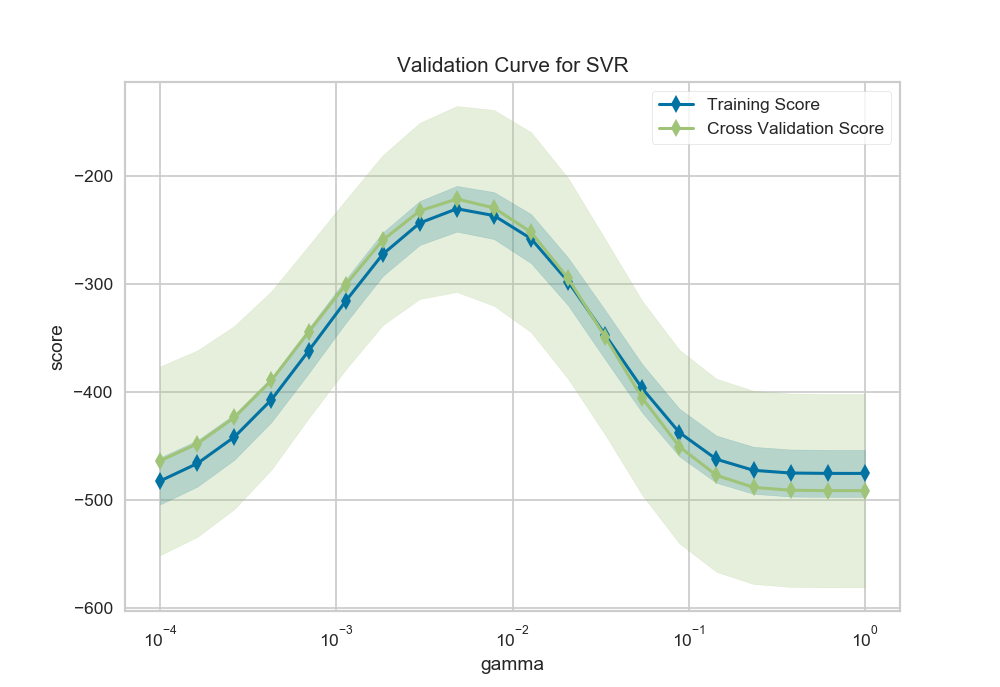

In [40]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)
param_range = np.logspace(-4, 0, 20)

viz = ValidationCurve(
    SVR(), param_name="gamma", param_range=param_range,
    logx=True, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1,
)

viz.fit(X_train, y_train)
viz.poof()

In [34]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', SVR())
])

parameters = {
    'regression__gamma': np.logspace(-2, -1, num = 20),
    'regression__epsilon': np.linspace(0, 1, num = 10),
    'regression__C': [1, 10, 100, 1000],
    'regression__kernel': ['rbf']
}

# Set parameter turning values and create a grid of models to run
scorer = make_scorer(mean_squared_error, greater_is_better = False)
gridSearch = GridSearchCV(pipeline, parameters, cv = 10, scoring = scorer, verbose = 1, n_jobs = -1)

In [57]:
from time import time

for f in featureList:
    print("Performing grid search...")
    #print("pipeline:", [name for name, _ in pipeline.steps])
    #print("parameters:")

    #pprint(parameters)
    t0 = time()

    gridSearch.fit(X[f], y)
    print("done in %0.3fs" % (time() - t0))
    #print()

    print("Best score: %0.3f" % gridSearch.best_score_)
    print("Best parameters set:")
    best_parameters = gridSearch.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
       print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    gridEstimator = gridSearch.best_estimator_

    EvaluateRegressionEstimator(gridEstimator, X[f], y, cv)

Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 936 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 2436 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 4536 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 7236 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   50.2s finished


done in 50.393s
Best score: -124.752
Best parameters set:
	regression__C: 100
	regression__epsilon: 1.0
	regression__gamma: 0.01
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 7.7535
The average MAE percentage (MAPE) for all cv folds is: 	 13.704
The average RMSE for all cv folds is: 			 11.184
*********************************************************
Cross Validation Fold Mean Error Scores
Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2456 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 6456 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   21.5s finished


done in 21.590s
Best score: -92.394
Best parameters set:
	regression__C: 1000
	regression__epsilon: 0.8888888888888888
	regression__gamma: 0.0206913808111479
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 6.9746
The average MAE percentage (MAPE) for all cv folds is: 	 13.752
The average RMSE for all cv folds is: 			 10.127
*********************************************************
Cross Validation Fold Mean Error Scores
Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1240 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 3240 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 6040 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   45.3s finished


done in 45.442s
Best score: -107.311
Best parameters set:
	regression__C: 100
	regression__epsilon: 1.0
	regression__gamma: 0.01
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 7.2511
The average MAE percentage (MAPE) for all cv folds is: 	 13.257
The average RMSE for all cv folds is: 			 10.734
*********************************************************
Cross Validation Fold Mean Error Scores


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X[featuresLasso], y, random_state=42, test_size=.2)

# Scale data after splitting out test data
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<IPython.core.display.Javascript object>


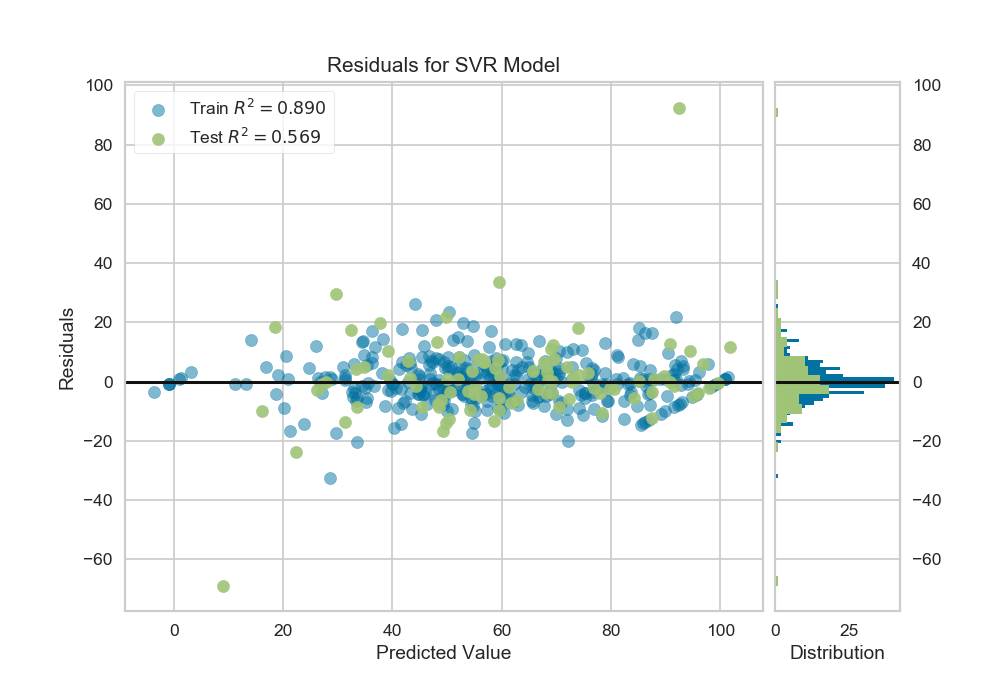

In [53]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Instantiate the linear model and visualizer
reg = SVR(C = 1000, epsilon = 0.8888888888888888, gamma = 0.0206913808111479, kernel = 'rbf')
visualizer = ResidualsPlot(reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

<IPython.core.display.Javascript object>


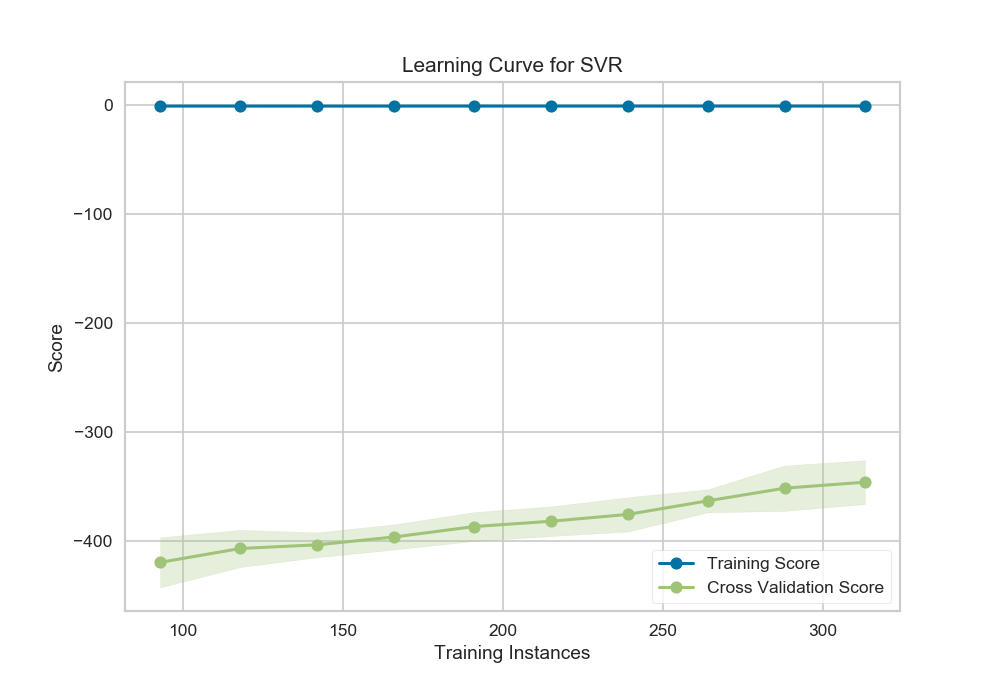

In [61]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the learning curve visualizer, fit and poof
sizes = np.linspace(0.3, 1.0, 10)

viz = LearningCurve(SVR(C = 1000, epsilon = 0.8888888888888888, gamma = 0.0206913808111479, kernel = 'rbf'), train_sizes=sizes, scoring=scorer)
viz.fit(X[f], y)
viz.poof()

<IPython.core.display.Javascript object>


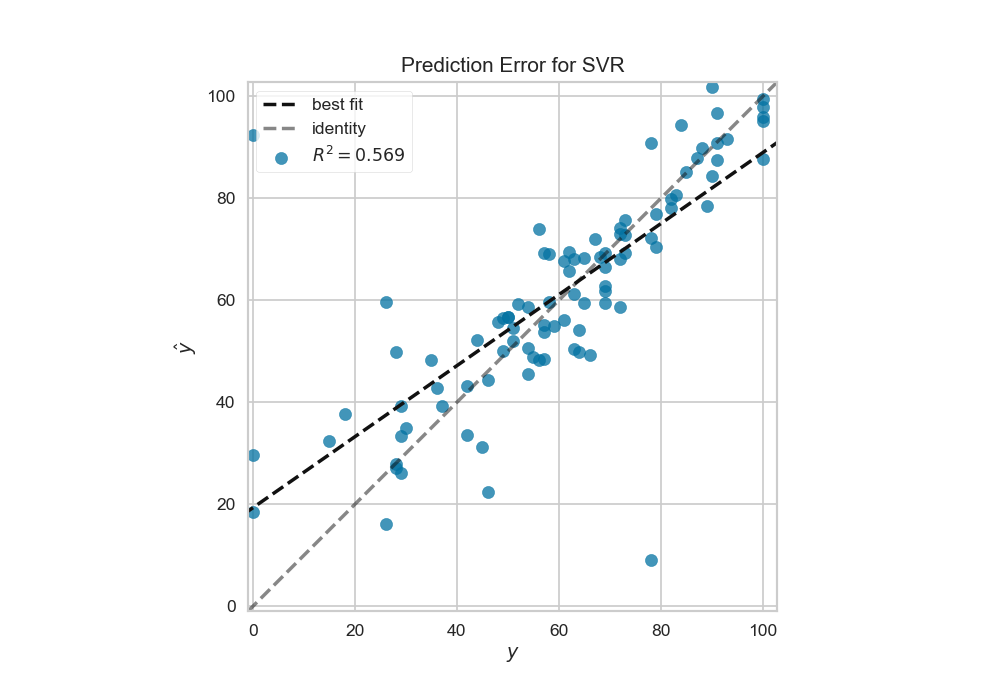

In [62]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Instantiate the linear model and visualizer
reg = SVR(C = 1000, epsilon = 0.8888888888888888, gamma = 0.0206913808111479, kernel = 'rbf')
visualizer = PredictionError(reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

<a id="Model2"></a>
### School %

In [85]:
# Brett's directory
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directory
#%cd "C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\Project\2017\Machine Learning Datasets"
dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

# Target data
y = dfPublicHS['ALL_All Students (Total or Subtotal_ENROLL_sch_pct']

# Credit: https://www.kaggle.com/saravanann/santander
# Drop any columns that have zero variance
totalColNum = dfPublicHS.shape[1]
sel = VarianceThreshold()
sel.fit(dfPublicHS)
keepCols = sel.get_support(indices=True)
dfColIndex = np.arange(dfPublicHS.columns.size)
dropCol = np.delete(dfColIndex, keepCols)
dfPublicHS = dfPublicHS.drop(dfPublicHS.columns[dropCol], axis = 1)

print("Columns Dropped: {}".format(len(dropCol)))

# These names seem to cause problems so let's give them friendlier names
renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
              '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
              '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
              '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
              '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
              '_1_to_1_access_Yes': 'one_to_one_access_yes',
              '4_10_Years_LEA_Exp_Pct_Prin': 'Four_to_Ten_Years_Exp_Pct_prin',
              '10+_Years_LEA_Exp_Pct_Prin': 'Ten_Plus_Years_LEA_Exp_Pct_prin',
              '0_3_Years_LEA_Exp_Pct_Prin': 'One_to_three_lea_exp_pct_prin'}

# Remove any trailing white spaces
dfPublicHS.columns = dfPublicHS.columns.str.strip()

# Remove any spaces, slashes, or hyphens
dfPublicHS.columns = dfPublicHS.columns.str.replace(r' |/|-|,|\+|:', "_")

# Rename columns
dfPublicHS.rename(columns=renameCols, inplace = True)

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets
Columns Dropped: 1


In [86]:
# Drop any remaining variables related to the ACT score (such as ACT benchmarks) to not bias our model
dropCols = dfPublicHS.filter(regex = r'sch_pct')
dfPublicHS.drop(dropCols, axis = 1, inplace = True)

# Data
X = dfPublicHS.iloc[:,0:dfPublicHS.shape[1] - 1]

In [87]:
# Credit: https://www.kaggle.com/cast42/select-features-rfecv/code
p = 40
selectF_regression = SelectPercentile(f_regression, percentile=p).fit(X, y)
select_mutual = SelectPercentile(mutual_info_regression, percentile=p).fit(X, y)

f_regression_selected = selectF_regression.get_support()
f_regression_selected_features = [ f for i,f in enumerate(X.columns) if f_regression_selected[i]]
print('f_regression selected {} features.'.format(f_regression_selected.sum()))

mutual_selected = select_mutual.get_support()
mutual_selected_features = [ f for i,f in enumerate(X.columns) if mutual_selected[i]]
print('Mutual Info Regression selected {} features.'.format(mutual_selected.sum()))

selected = f_regression_selected & mutual_selected
print('Intersection of F_Regression & Mutual Info Regression: {} features'.format(selected.sum()))
featuresFull = [ f for f,s in zip(X.columns, selected) if s]

f_regression selected 158 features.
Mutual Info Regression selected 158 features.
Intersection of F_Regression & Mutual Info Regression: 114 features


In [88]:
cv = ShuffleSplit(n_splits = 10, test_size  = 0.2, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(X[featuresFull], y, random_state=42, test_size=.2)

<IPython.core.display.Javascript object>


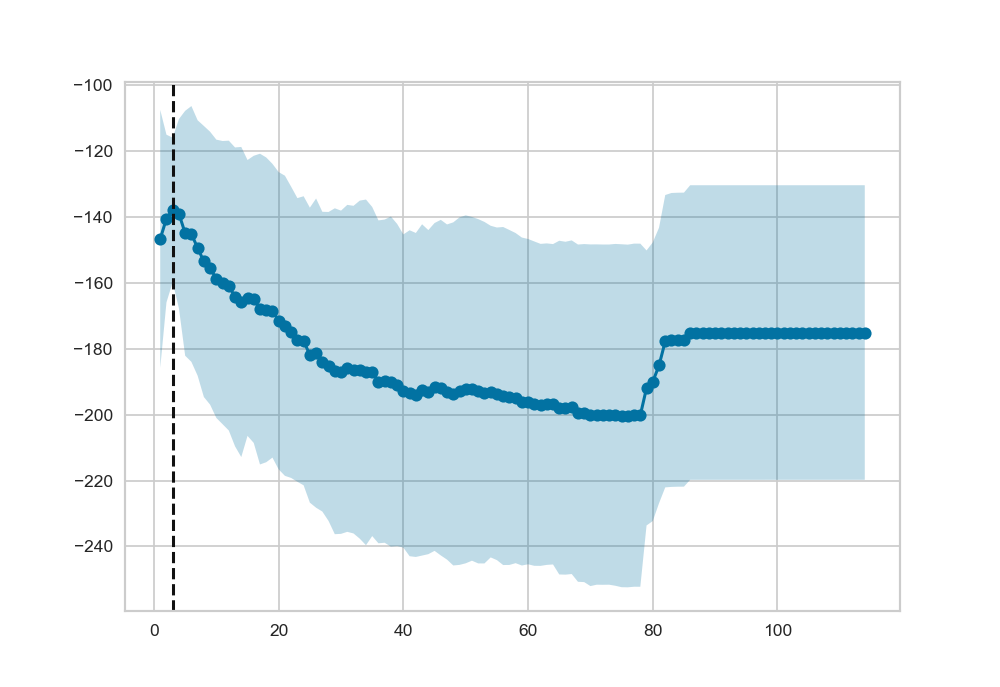

The optimal number of features is 3


In [89]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

selector = RFECV(Lasso(), cv = cv, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
featuresLasso = [f for f,s in zip(X_train.columns, selector.support_) if s]

sendSlackMessage("RFE finished", "Brett")

<IPython.core.display.Javascript object>


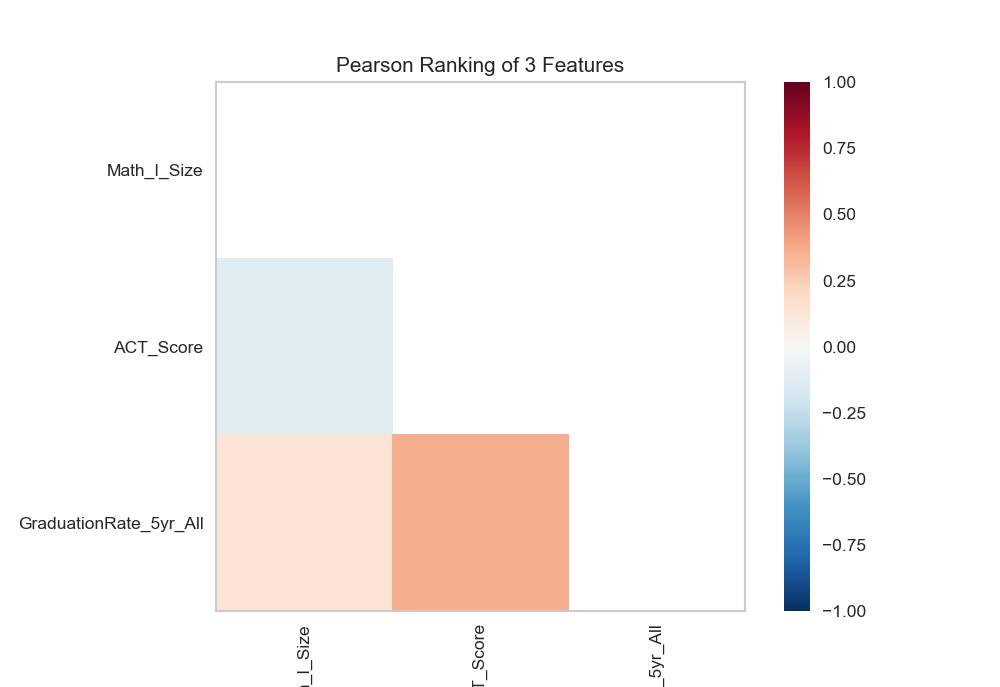

In [90]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresLasso, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresLasso], y)
vis.transform(dfPublicHS[featuresLasso])
vis.poof()

<IPython.core.display.Javascript object>


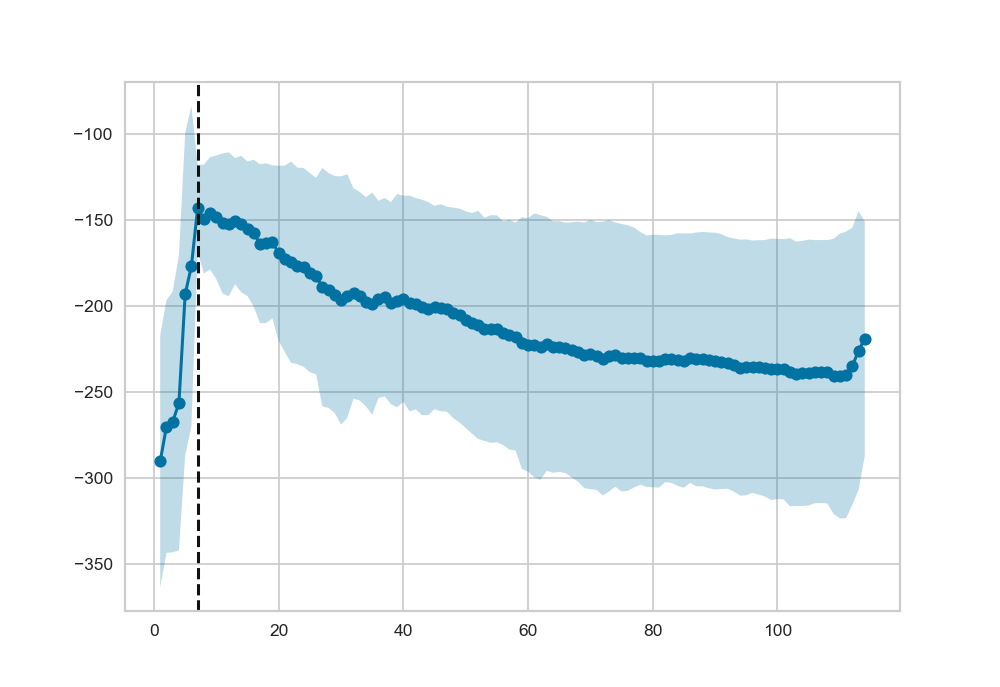

The optimal number of features is 7


In [91]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

selector = RFECV(Ridge(), cv = cv, scoring='neg_mean_squared_error')
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
featuresRidge = [f for f,s in zip(X_train.columns, selector.support_) if s]

sendSlackMessage("RFE finished", "Brett")

<IPython.core.display.Javascript object>


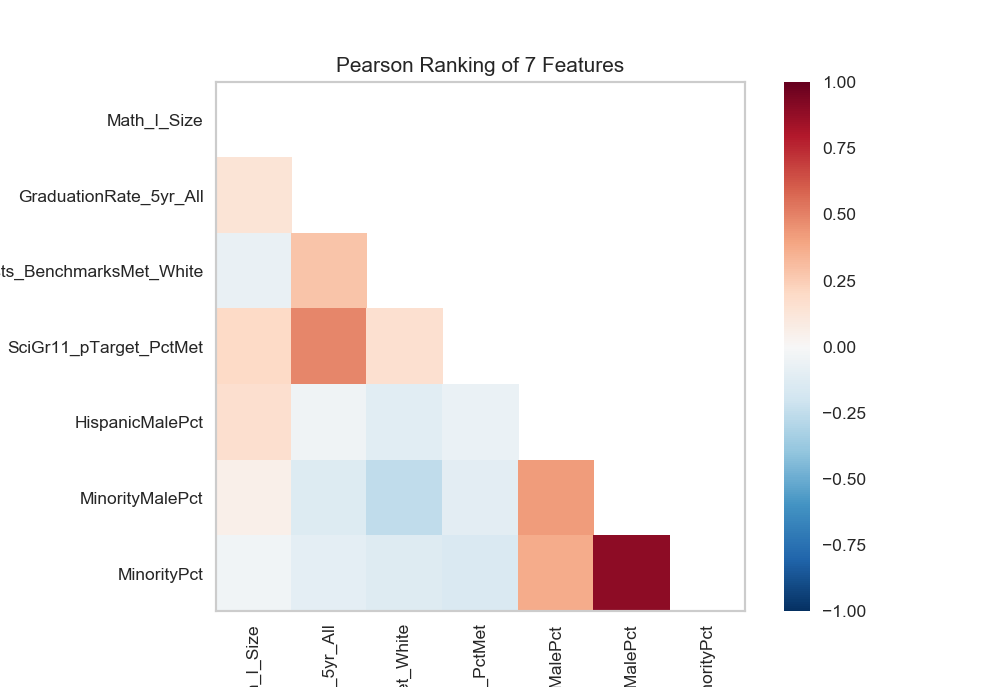

In [92]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

vis = Rank2D(features=featuresRidge, algorithm='pearson', ax = ax)

vis.fit(dfPublicHS[featuresRidge], y)
vis.transform(dfPublicHS[featuresRidge])
vis.poof()

<IPython.core.display.Javascript object>


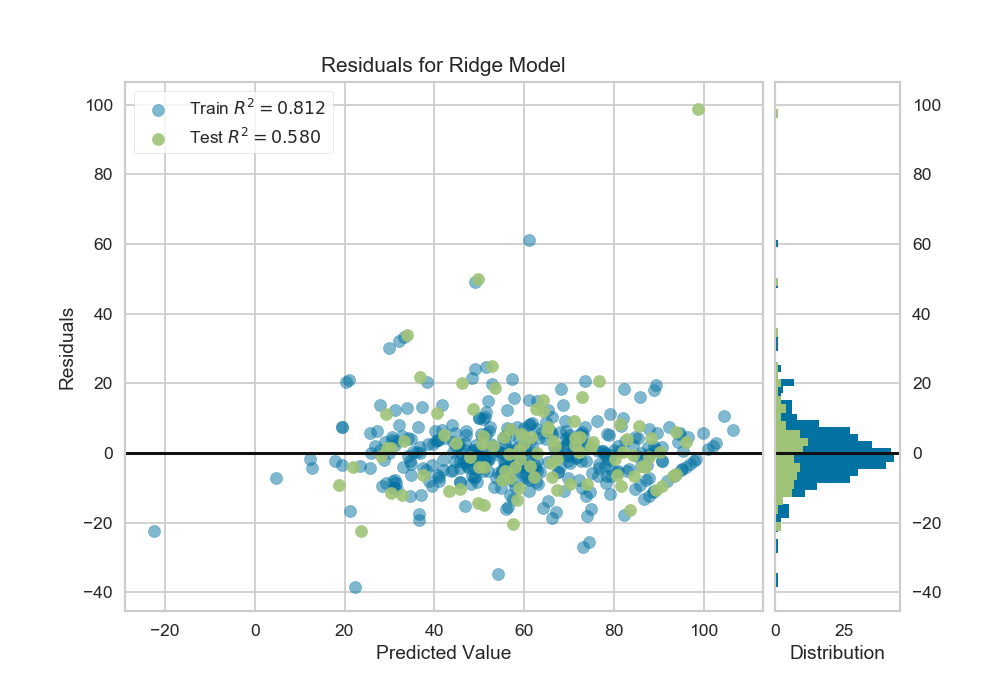

In [24]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Instantiate the linear model and visualizer
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

<IPython.core.display.Javascript object>


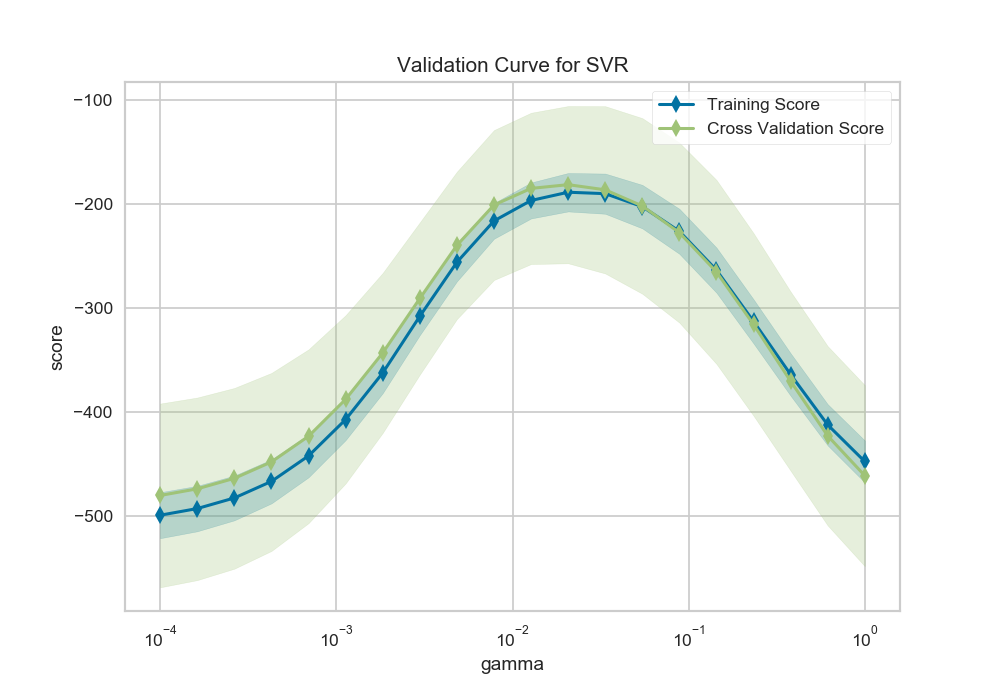

In [26]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42)
param_range = np.logspace(-4, 0, 20)

viz = ValidationCurve(
    SVR(), param_name="gamma", param_range=param_range,
    logx=True, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1,
)

viz.fit(X_train, y_train)
viz.poof()

In [95]:
featureList = [featuresFull, featuresLasso, featuresRidge]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', SVR())
])

parameters = {
    'regression__gamma': np.logspace(-2, -1, num = 20),
    'regression__epsilon': np.linspace(0, 1, num = 10),
    'regression__C': [1, 10, 100, 1000],
    'regression__kernel': ['rbf']
}

# Set parameter turning values and create a grid of models to run
scorer = make_scorer(mean_squared_error, greater_is_better = False)
gridSearch = GridSearchCV(pipeline, parameters, cv = 10, scoring = scorer, verbose = 1, n_jobs = -1)

In [96]:
from time import time

for f in featureList:
    print("Performing grid search...")
    #print("pipeline:", [name for name, _ in pipeline.steps])
    #print("parameters:")

    #pprint(parameters)
    t0 = time()

    gridSearch.fit(X[f], y)
    print("done in %0.3fs" % (time() - t0))
    #print()

    print("Best score: %0.3f" % gridSearch.best_score_)
    print("Best parameters set:")
    best_parameters = gridSearch.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
       print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    gridEstimator = gridSearch.best_estimator_

    EvaluateRegressionEstimator(gridEstimator, X[f], y, cv)

Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 287 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 787 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1487 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2387 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 3487 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 4787 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 6287 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 7977 out of 8000 | elapsed:   55.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   55.2s finished


done in 55.358s
Best score: -178.165
Best parameters set:
	regression__C: 100
	regression__epsilon: 1.0
	regression__gamma: 0.01
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 9.5591
The average MAE percentage (MAPE) for all cv folds is: 	 17.249
The average RMSE for all cv folds is: 			 13.383
*********************************************************
Cross Validation Fold Mean Error Scores
Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2456 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 6456 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   17.4s finished


done in 17.555s
Best score: -128.981
Best parameters set:
	regression__C: 10
	regression__epsilon: 0.1111111111111111
	regression__gamma: 0.08858667904100823
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 7.5886
The average MAE percentage (MAPE) for all cv folds is: 	 16.687
The average RMSE for all cv folds is: 			 11.131
*********************************************************
Cross Validation Fold Mean Error Scores
Performing grid search...
Fitting 10 folds for each of 800 candidates, totalling 8000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1848 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 4848 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 7764 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 8000 out of 8000 | elapsed:   28.4s finished


done in 28.546s
Best score: -124.152
Best parameters set:
	regression__C: 100
	regression__epsilon: 0.0
	regression__gamma: 0.07847599703514611
	regression__kernel: 'rbf'
The average MAE for all cv folds is: 			 8.0689
The average MAE percentage (MAPE) for all cv folds is: 	 16.536
The average RMSE for all cv folds is: 			 11.366
*********************************************************
Cross Validation Fold Mean Error Scores


In [27]:
# Set parameter turning values and create a grid of models to run
gamma_opts = np.logspace(-2, -1, num = 20)
param_grid = dict(gamma=gamma_opts, C=[1,10,100,1000], kernel=['rbf'])
gridRBF = GridSearchCV(SVR(), param_grid=param_grid, cv=cv)

In [28]:
# Train SVM model on the each different parameter value
print("Training started at: {}".format(datetime.now().time()))
gridRBF.fit(X_train, y_train)

sendSlackMessage("Best Model Found.", "Brett")

bestValues = gridRBF.best_params_

print("Best parameters set found on development set: {}".format(bestValues))

Training started at: 13:40:25.415925
Best parameters set found on development set: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


<IPython.core.display.Javascript object>


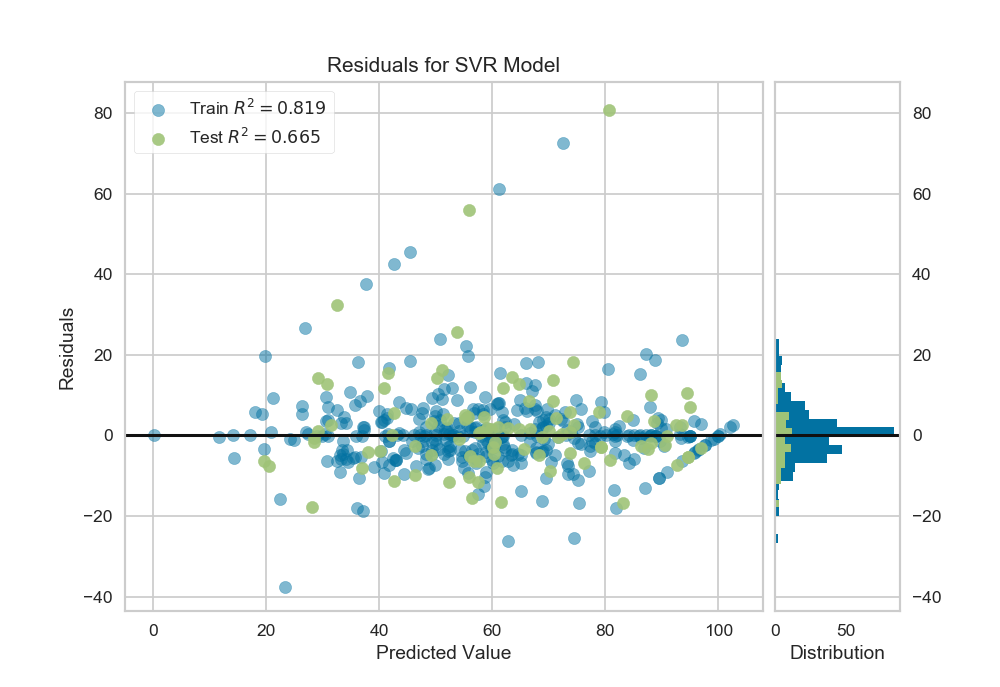

In [29]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Instantiate the linear model and visualizer
reg = SVR(C = bestValues['C'], gamma = bestValues['gamma'], kernel='rbf')
visualizer = ResidualsPlot(reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data